In [1]:
# Check available cores
import multiprocessing

multiprocessing.cpu_count()

12

# 1. Import python libraries

In [2]:
!pip install --upgrade scikit-learn
!pip install -U xgboost
!pip install seaborn
!pip install pandas
!pip install matplotlib

Requirement already up-to-date: scikit-learn in /home/themi-server/anaconda3/lib/python3.8/site-packages (0.23.2)
Requirement already up-to-date: xgboost in /home/themi-server/anaconda3/lib/python3.8/site-packages (1.2.1)


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import joblib

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# 2. Load, check, and prepare the data

Data source: https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

In [4]:
data = pd.read_csv("data_breast_cancer.csv")

In [5]:
print(data.shape, end = "\n\n\n")
print(data.head())
print(data.info())


(569, 32)


         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_wor

Target column: "diagnosis"

In [6]:
print(data.diagnosis.value_counts(), end = '\n\n\n')
print(data.info(), end = '\n\n\n')
print(data.isnull().sum())

B    357
M    212
Name: diagnosis, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 n

In [7]:
print("The dataset contain {} duplicates".format(sum(data.duplicated())))

The dataset contain 0 duplicates


Removing outliers

In [8]:
data.drop(['id'], axis = 1, inplace = True)

# numerical data
x = data.select_dtypes("float64")

# identify outliers in the dataset
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1

print("Original shape: {}".format(data.shape), end = '\n\n\n')
print("Shape after outliers removal: {}".format(data.loc[mask,:].shape), end = '\n\n\n')

if (data.shape[0] > data.loc[mask,:].shape[0]):
  print("The numerical columns contain outliers")
else:
  print("The numerical columns DO NOT contain outliers")

data = data.loc[mask,:]

Original shape: (569, 31)


Shape after outliers removal: (540, 31)


The numerical columns contain outliers


In [9]:
# define a categorical encoding for target variable
le = LabelEncoder()

# fit and transoform y_train
data["diagnosis"] = le.fit_transform(data.diagnosis)
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
4,1,20.29,14.34,135.1,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.2,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
6,1,18.25,19.98,119.6,1040.0,0.09463,0.10900,0.1127,0.07400,0.1794,...,22.88,27.66,153.2,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368


Diagnosis:
  Malignant = 1,
  Benign = 0

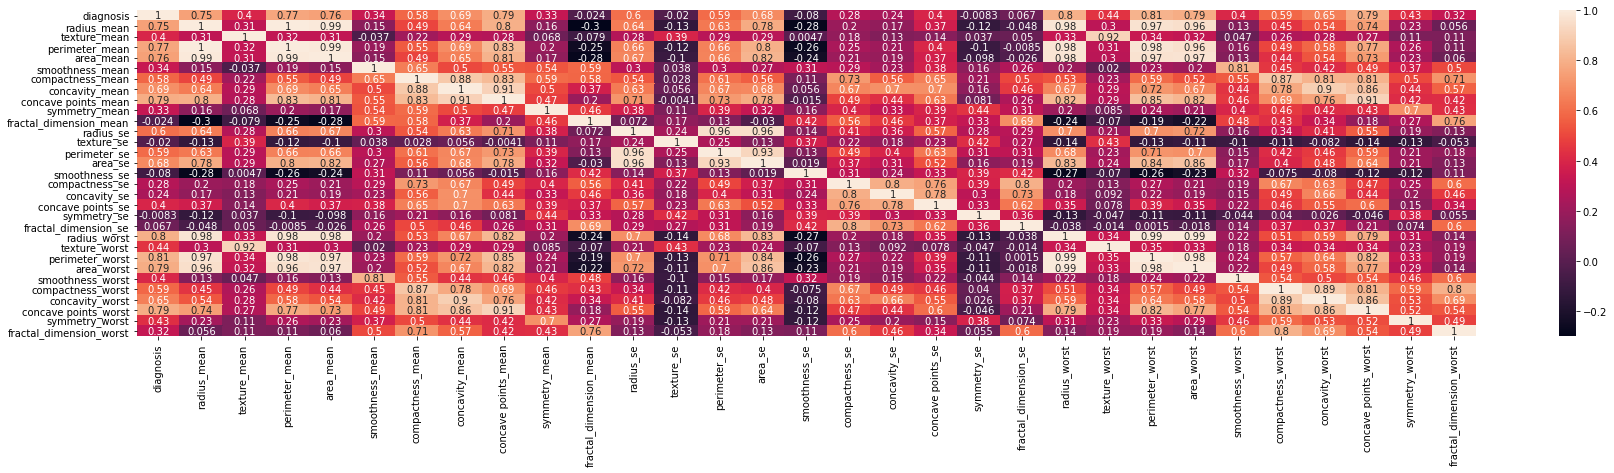

In [10]:
correlations = data.corr()
plt.figure(figsize = (30, 20))
sns.heatmap(data = correlations, annot = True)

# 3. Pipeline

In [11]:
# Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSelector( BaseEstimator, TransformerMixin ):
    # Class Constructor 
    def __init__( self, feature_names ):
        self.feature_names = feature_names 
    
    # Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    # Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self.feature_names ]

In [12]:
# Transform numerical features
class NumericalTransformer( BaseEstimator, TransformerMixin ):
  # Class constructor method that takes a model parameter as argument
  # model 0: minmax
  # model 1: standard
  # model 2: without scaler
  def __init__(self, model = 2):
    self.model = model
    self.colnames = None

  # Return self nothing else to do here    
  def fit( self, X, y = None ):
    return self

  # Return columns names after transformation
  def get_feature_names(self):
        return self.colnames 
        
  # Transformer method we wrote for this transformer 
  def transform(self, X , y = None ):
    df = X.copy()
    
    # Update columns name
    self.colnames = df.columns.tolist()
    
    if self.model == 0: 
      scaler = MinMaxScaler()
      df = scaler.fit_transform(df)
    elif self.model == 1:
      scaler = StandardScaler()
      df = scaler.fit_transform(df)
    else:
      df = df.values

    return df

## Testing transformation

In [13]:
model = FeatureSelector(data.select_dtypes("float64").columns.to_list())
df = model.fit_transform(data)
print(df.shape, end = "\n\n\n")
df.head()

(540, 30)




,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
4,20.29,14.34,135.1,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.2,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
6,18.25,19.98,119.6,1040.0,0.09463,0.10900,0.1127,0.07400,0.1794,0.05742,...,22.88,27.66,153.2,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368


In [14]:
model = NumericalTransformer(model = 2)
dfTransformed = model.fit_transform(df)
dfTransformed

array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
        1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
        8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
        8.758e-02],
       ...,
       [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
        7.820e-02],
       [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
        1.240e-01],
       [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
        7.039e-02]])

Training and test

In [15]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(labels = "diagnosis", axis = 1),
                                                    data["diagnosis"],
                                                    test_size = 0.20,
                                                    random_state = 5,
                                                    shuffle = True,
                                                    stratify = data["diagnosis"])

In [16]:
print(y_train.head(), end = "\n\n\n")
print(y_train.value_counts(), end = '\n\n\n')
print(y_test.value_counts(), end = '\n\n\n')

491    0
433    1
568    0
543    0
160    0
Name: diagnosis, dtype: int64


0    282
1    150
Name: diagnosis, dtype: int64


In [17]:
# Numerical features
numerical_features = x_train.select_dtypes("float64").columns.to_list()

# Defining the steps in the numerical pipeline
numerical_pipeline = Pipeline(steps = [('num_selector', FeatureSelector(numerical_features)),
                                       ('num_transformer', NumericalTransformer())])

## Testing pipeline

In [18]:
new_data = numerical_pipeline.fit_transform(x_train)
numnames = numerical_pipeline.get_params()["num_transformer"].get_feature_names()
df = pd.DataFrame(new_data, columns = numnames)
print(df.shape, end = "\n\n\n")
df.head()

(432, 30)




,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.85,13.23,114.60,992.1,0.07838,0.06217,0.04445,0.04178,0.1220,0.05243,...,19.820,18.42,127.10,1210.0,0.09862,0.09976,0.1048,0.08341,0.1783,0.05871
1,18.82,21.97,123.70,1110.0,0.10180,0.13890,0.15940,0.08744,0.1943,0.06132,...,22.660,30.93,145.30,1603.0,0.13900,0.34630,0.3912,0.17080,0.3007,0.08314
2,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.00000,0.2871,0.07039
3,13.21,28.06,84.88,538.4,0.08671,0.06877,0.02987,0.03275,0.1628,0.05781,...,14.370,37.17,92.48,629.6,0.10720,0.13810,0.1062,0.07958,0.2473,0.06443
4,11.75,20.18,76.10,419.8,0.10890,0.11410,0.06843,0.03738,0.1993,0.06453,...,13.320,26.21,88.91,543.9,0.13580,0.18920,0.1956,0.07909,0.3168,0.07987


The default behavior is do not transform the data

In [19]:
data[(data.radius_mean == df.radius_mean[0]) & (data.texture_mean == df.texture_mean[0])]

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
491,0,17.85,13.23,114.6,992.1,0.07838,0.06217,0.04445,0.04178,0.122,...,19.82,18.42,127.1,1210.0,0.09862,0.09976,0.1048,0.08341,0.1783,0.05871


# 4. Algorithm tuning

In [20]:
# Global variables
seed = 5
num_folds = 10
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

In [21]:
# The full pipeline
pipe = Pipeline(steps = [("numerical_pipeline", numerical_pipeline),
                         ("fs", SelectKBest()),
                         ("clf", XGBClassifier())])
# Create a dictionary with the hyperparameters
search_space = [{"clf": [XGBClassifier()],
                 "clf__n_estimators": range(50, 500, 50),
                 "clf__max_depth": [3, 6, 8, 10, 15],
                 "clf__learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
                 "clf__subsample": np.arange(0.1, 1.0, 0.1),
                 "clf__colsample_bytree": np.arange(0.1, 1.0, 0.1),
                 "clf__tree_method": ["auto", "gpu_hist"],
                 "fs__score_func": [f_classif, mutual_info_classif, chi2],
                 "fs__k": range(5, 30, 5),
                 "numerical_pipeline__num_transformer__model": range(0, 2, 1)},
                {"clf": [DecisionTreeClassifier()],
                 "clf__criterion": ["gini", "entropy"],
                 "clf__splitter": ["best"],
                 "fs__score_func": [f_classif, mutual_info_classif, chi2],
                 "fs__k": range(5, 30, 5),
                 "numerical_pipeline__num_transformer__model": range(0, 2, 1)},
                {"clf": [KNeighborsClassifier()],
                 "clf__n_neighbors": range(3, 10, 1),
                 "fs__score_func": [f_classif, mutual_info_classif, chi2],
                 "fs__k": range(5, 30, 5),
                 "numerical_pipeline__num_transformer__model": range(0, 2, 1)},
                {"clf": [RandomForestClassifier()],
                 "clf__n_estimators": range(50, 500, 50),
                 "clf__max_depth": [3, 6, 8, 10, 15],
                 "clf__criterion": ["gini", "entropy"],
                 "fs__score_func": [f_classif, mutual_info_classif, chi2],
                 "fs__k": range(5, 30, 5),
                 "numerical_pipeline__num_transformer__model": range(0, 2, 1)},
                ]

# Create grid search
kfold = StratifiedKFold(n_splits = num_folds, random_state = seed, shuffle = True)

#grid = GridSearchCV(estimator = pipe, 
                    #param_grid = search_space,
                    #cv = kfold,
                    #scoring = scoring,
                    #return_train_score = True,
                    #n_jobs = -1,
                    #refit = "Accuracy")

grid = RandomizedSearchCV(estimator = pipe, 
                    param_distributions = search_space,
                    n_iter = 150000,
                    cv = kfold,
                    scoring = scoring,
                    return_train_score = True,
                    n_jobs = -1,
                    refit = "Accuracy")

# Fit grid search
all_models = grid.fit(x_train,y_train)

print("Best: %f using %s" % (all_models.best_score_, all_models.best_params_))

Best: 0.988425 using {'numerical_pipeline__num_transformer__model': 1, 'fs__score_func': <function f_classif at 0x7f3988f1b790>, 'fs__k': 25, 'clf__tree_method': 'auto', 'clf__subsample': 0.5, 'clf__n_estimators': 400, 'clf__max_depth': 3, 'clf__learning_rate': 0.2, 'clf__colsample_bytree': 0.1, 'clf': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.1, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.2, max_delta_step=None, max_depth=3,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=0.5, tree_method='auto',
              validate_parameters=None, verbosity=None)}


In [22]:
print("Best: %f using %s" % (all_models.best_score_, all_models.best_params_))

Best: 0.988425 using {'numerical_pipeline__num_transformer__model': 1, 'fs__score_func': <function f_classif at 0x7f3988f1b790>, 'fs__k': 25, 'clf__tree_method': 'auto', 'clf__subsample': 0.5, 'clf__n_estimators': 400, 'clf__max_depth': 3, 'clf__learning_rate': 0.2, 'clf__colsample_bytree': 0.1, 'clf': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.1, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.2, max_delta_step=None, max_depth=3,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=0.5, tree_method='auto',
              validate_parameters=None, verbosity=None)}


In [23]:
predict = all_models.predict(x_test)

In [24]:
confusion_matrix(predict, y_test,
                 labels = [1, 0])

array([[35,  1],
       [ 2, 70]])

In [25]:
print(accuracy_score(y_test, predict))
print(classification_report(y_test, predict))

0.9722222222222222
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.97      0.95      0.96        37

    accuracy                           0.97       108
   macro avg       0.97      0.97      0.97       108
weighted avg       0.97      0.97      0.97       108



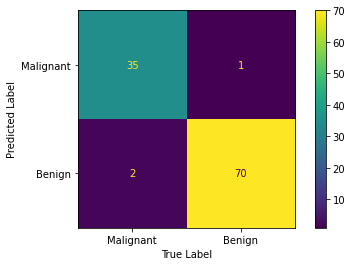

In [26]:
fig, ax = plt.subplots(1, 1, figsize = (7, 4))

ConfusionMatrixDisplay(confusion_matrix(predict, y_test, labels = [1, 0]),
                       display_labels = ["Malignant", "Benign"]).plot(values_format = ".0f", ax = ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [27]:
features = all_models.best_estimator_.named_steps["fs"]
features_num = all_models.best_estimator_.named_steps["numerical_pipeline"]
features_num.get_params()["num_transformer"].get_feature_names()

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

In [28]:
selected_columns = [value for (value, filter) in zip(features_num.get_params()["num_transformer"].get_feature_names(), features.get_support()) if filter]
selected_columns

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'radius_se',
 'perimeter_se',
 'area_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

Feature contribution

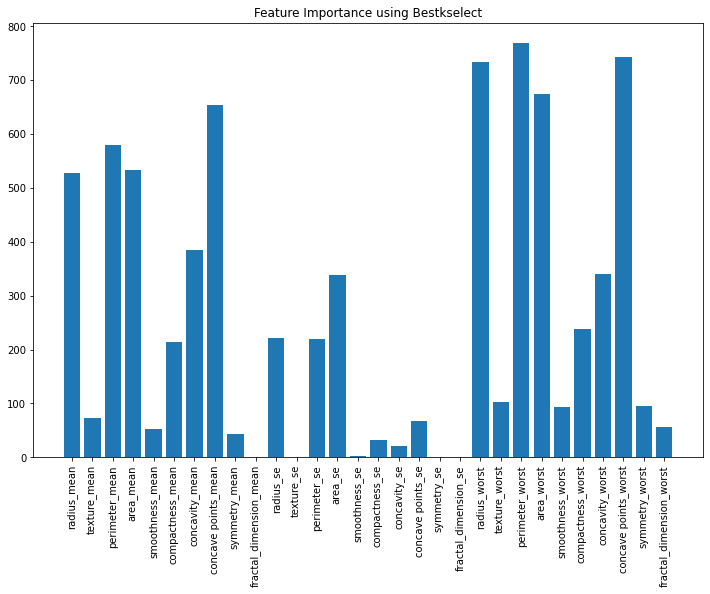

In [29]:
fig, ax = plt.subplots(1, 1, figsize = (12, 8))

xticks = [x for x in range(len(features.scores_))] 
ax.bar(xticks, features.scores_)
ax.set_xticks(xticks)
ax.set_xticklabels(features_num.get_params()["num_transformer"].get_feature_names(), rotation = 90)
ax.set_title("Feature Importance using Bestkselect")
plt.show()

In [30]:
classifier = all_models.best_estimator_.named_steps['clf']
classifier

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='auto', validate_parameters=1, verbosity=None)

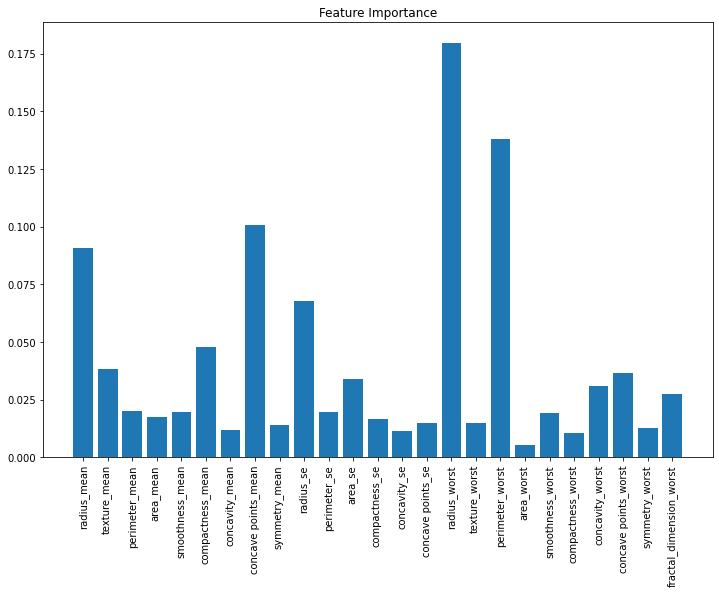

In [31]:
fig, ax = plt.subplots(1, 1, figsize = (12, 8))

xticks = [x for x in range(len(classifier.feature_importances_))] 
ax.bar(xticks, classifier.feature_importances_)
ax.set_xticks(xticks)
ax.set_xticklabels(selected_columns, rotation = 90)
ax.set_title("Feature Importance")
plt.show()

# 5. Saving model

In [32]:
# Save the model using joblib
with open("pipe.joblib", "wb") as file:
  joblib.dump(all_models, file)

Checking saved model

In [33]:
# Using model
with open("pipe.joblib", "rb") as file:
  model = joblib.load(file)

predict = model.predict(x_test)

In [43]:
print(accuracy_score(y_test, predict))
print(classification_report(y_test, predict))

0.9722222222222222
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.97      0.95      0.96        37

    accuracy                           0.97       108
   macro avg       0.97      0.97      0.97       108
weighted avg       0.97      0.97      0.97       108

